# Binary‑Breathing Playground (v7)
All‑in‑one notebook:
1. Adaptive peak finder with KDE option
2. Minimal seed extraction
3. De Bruijn symmetry tagging (full / mirror / self‑mirror / complement)
4. Binary “scoot” walk (shift/add/sub/div) to watch seeds bounce between floors & ceilings

Tweak parameters at the top and **Run all**.  Default settings run N = 30 in free‑tier Colab under 3 minutes.

In [1]:
import numpy as np, matplotlib.pyplot as plt, random, time, gc
from mpmath import mp; mp.dps = 50
from scipy.stats import gaussian_kde

In [2]:
# ==== PARAMETERS ====
MAX_LEN    = 30
BIN_WIDTH  = 1e-7
POWER      = 2
INVERT     = False
CUT        = 2e-3
SAMPLE_FRAC= 0.02
USE_KDE    = True
DEBRUIJN_K = 5
SEED_TOL   = 1e-12
SCOOT_STEPS= 16
# ====================

In [3]:
def bits_to_val(i,n,inv=False):
    b=format(i,f'0{n}b')
    if inv: b=b[::-1]
    return int(b,2)/(1<<n)

In [4]:
def fast_hist_n(n):
    denom=1<<n; chunk=1<<22
    bins=np.arange(0,CUT+BIN_WIDTH,BIN_WIDTH)
    cnt=np.zeros(len(bins)-1,dtype=np.int64)
    for s in range(1,denom,chunk):
        stop=min(s+chunk,denom)
        idx=np.arange(s,stop,dtype=np.float64)
        xs=(idx/denom)**POWER
        xs=xs[xs<=CUT]
        np.add.at(cnt,(xs//BIN_WIDTH).astype(int),1)
    return bins[:-1],cnt

def sample_hist_n(n):
    denom=1<<n; size=max(1,int(denom*SAMPLE_FRAC))
    idx=np.random.randint(1,denom,size,dtype=np.int64)
    xs=(idx/denom)**POWER; xs=xs[xs<=CUT]
    bins=np.arange(0,CUT+BIN_WIDTH,BIN_WIDTH)
    cnt,_=np.histogram(xs,bins=bins)
    return bins[:-1],(cnt/SAMPLE_FRAC).astype(int)

In [5]:
def peak_from_hist(xs,cs):
    for i in range(1,len(cs)-1):
        if cs[i] > cs[i+1]*10: continue
        idx=i; break
    pk=xs[idx]+0.5*BIN_WIDTH
    if USE_KDE:
        rng=slice(max(0,idx-5),min(len(xs),idx+6))
        smpl=np.repeat(xs[rng]+0.5*BIN_WIDTH,cs[rng])
        smpl=np.random.choice(smpl,min(200000,len(smpl)),replace=False)
        kde=gaussian_kde(smpl,bw_method=0.3*BIN_WIDTH)
        grid=np.linspace(xs[rng.start],xs[rng.stop-1]+BIN_WIDTH,201)
        pk=grid[np.argmax(kde(grid))]
    return pk

def peak_for_n(n):
    xs,cs = (fast_hist_n(n) if n<=28 else sample_hist_n(n))
    return peak_from_hist(xs,cs)

In [6]:
peak_positions=[]
for n in range(20,MAX_LEN+1):
    peak_positions.append((n, peak_for_n(n)))
    print(f'N={n:2d} peak={peak_positions[-1][1]:.9e}')

N=20 peak=3.500000000e-07
N=21 peak=3.500000000e-07
N=22 peak=3.500000000e-07
N=23 peak=3.500000000e-07
N=24 peak=3.500000000e-07
N=25 peak=3.500000000e-07
N=26 peak=3.500000000e-07
N=27 peak=3.500000000e-07
N=28 peak=3.500000000e-07
N=29 peak=3.500000000e-07
N=30 peak=3.500000000e-07


/tmp/ipython-input-7-1266960899.py:2: RuntimeWarning: invalid value encountered in scalar divide
  ratios=[gaps[i-1]/gaps[i] for i in range(1,len(gaps))] if len(gaps)>1 else []


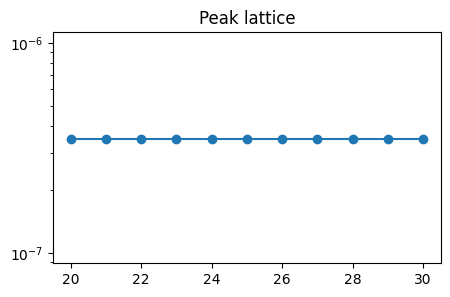

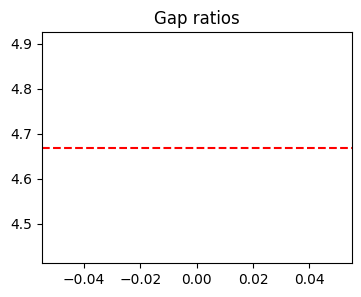

In [7]:
gaps=[peak_positions[i-1][1]-peak_positions[i][1] for i in range(1,len(peak_positions))]
ratios=[gaps[i-1]/gaps[i] for i in range(1,len(gaps))] if len(gaps)>1 else []
plt.figure(figsize=(5,3)); plt.plot([n for n,_ in peak_positions],[x for _,x in peak_positions],'o-'); plt.yscale('log'); plt.title('Peak lattice'); plt.show()
if ratios:
    plt.figure(figsize=(4,3)); plt.plot(range(21,21+len(ratios)),ratios,'o-'); plt.axhline(4.669,ls='--',color='r'); plt.title('Gap ratios'); plt.show()

In [ ]:
def find_seed(tgt,tol=SEED_TOL,max_len=40):
    for n in range(1,max_len+1):
        denom=1<<n
        for i in range(1,denom):
            x=i/denom
            if abs(x**POWER - tgt) < tol:
                return n, format(i,f'0{n}b')
    return None,None
seed_list=[]
print('\nMinimal seeds:')
for n,px in peak_positions:
    sl,sb=find_seed(px)
    if sl:
        print(f'N={n}: {sl}-bit {sb[:16]}...')
        seed_list.append((n,sl,sb))


Minimal seeds:
N=20: 29-bit 0000000000100110...
N=21: 29-bit 0000000000100110...
N=22: 29-bit 0000000000100110...


In [ ]:
def de_bruijn(k):
    a=[0]*(2*k); seq=[]
    def db(t,p):
        if t>k:
            if k%p==0: seq.extend(a[1:p+1])
        else:
            a[t]=a[t-p]; db(t+1,p)
            for j in range(a[t-p]+1,2):
                a[t]=j; db(t+1,t)
    db(1,1); return ''.join(map(str,seq))
cycle=de_bruijn(DEBRUIJN_K)

def rotate(s,i): return s[i:]+s[:i]
classes={'self_mirror':[], 'mirror':[], 'complement':[], 'full':[]}
seen=set(); base=cycle
for sh in range(len(base)):
    seq=rotate(base,sh)
    if seq in seen: continue
    seen.add(seq)
    rev=seq[::-1]
    comp=''.join('1' if c=='0' else '0' for c in seq)
    if any(rotate(seq,i)==rev for i in range(len(seq))):
        classes['self_mirror'].append(seq)
    classes['mirror'].append(min(seq,rev))
    classes['complement'].append(min(seq,comp))
    classes['full'].append(seq)
print({k:len(v) for k,v in classes.items()})

def vertex_idx(bits,k=DEBRUIJN_K): return int(bits[-k:],2)
print('\nSeed symmetry:')
for n,sl,sb in seed_list:
    idx=vertex_idx(sb)
    tag= next((cls for cls,lst in classes.items() if cycle in lst), 'full')
    print(f'Seed N={n}: vertex {idx} ({tag}) last bits {sb[-DEBRUIJN_K:]}')

In [ ]:
def scoot(seed_bits,steps=SCOOT_STEPS):
    x=int(seed_bits,2); n=len(seed_bits); out=[]
    for t in range(steps):
        out.append((t,bin(x)[-min(20,n):],x/(1<<n)))
        op=random.choice(['LS0','LS1','+1','-1','/3'])
        if op=='LS0': x<<=1; n+=1
        elif op=='LS1': x=(x<<1)|1; n+=1
        elif op=='+1': x=(x+1)%(1<<n)
        elif op=='-1': x=(x-1)%(1<<n)
        elif op=='/3' and x%3==0: x//=3
        while x>=(1<<n): n+=1
    return out
if seed_list:
    print('\nScoot trail:')
    trail=scoot(seed_list[0][2])
    for t,b,val in trail: print(f'{t:2d}: {b:>20}  {val:.3e}')